In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from gensim.models import Word2Vec
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [86]:
recipe_df = pd.read_csv('/Users/serenaliu/Documents/GitHub/FoodReceipeNLP/data/all_recipes.csv')
test_df = pd.read_csv('/Users/serenaliu/Downloads/out-of-sample.csv')

In [78]:
# No missing values found
recipe_df.isnull().any()

Name           False
Ingredients    False
Cuisine        False
dtype: bool

## Data Exploration

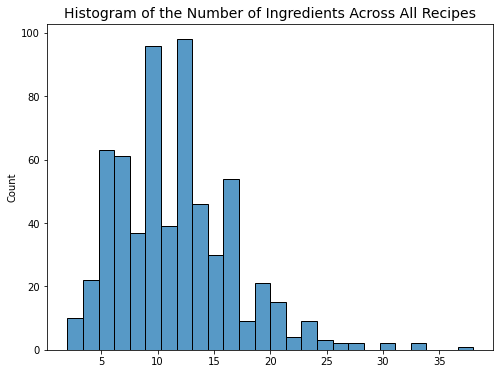

In [82]:
# Reference: https://www.kaggle.com/code/fritzpassow/recipe-ingredients-analysis
num_ingredients = [len(i.split(',')) for i in recipe_df['Ingredients']]

plt.figure(figsize = (8,6))
plt.title('Histogram of the Number of Ingredients Across All Recipes', fontsize = 14)
sns.histplot(num_ingredients)
plt.savefig('/Users/serenaliu/Documents/GitHub/FoodReceipeNLP/plot/hist_ingredients.png')

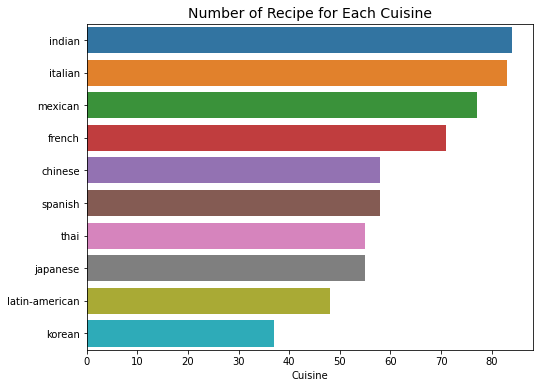

In [51]:
cusine_counts = recipe_df.Cuisine.value_counts()
plt.figure(figsize = (8,6))
plt.title('Number of Recipe for Each Cuisine', fontsize = 14)
sns.barplot(x = cusine_counts, y = cusine_counts.index)
plt.savefig('/Users/serenaliu/Documents/GitHub/FoodReceipeNLP/plot/barplot_cuisine.png')

## Data cleaning

In [5]:
# Reference: https://builtin.com/machine-learning/nlp-word2vec-python
def clean_text(df, col_name):
    '''
    Given a column of data, remove unwanted special characters from the text
    '''
    clean_txt = []
    for w in range(len(df[col_name])):
        desc = df[col_name][w].lower()

        # remove punctuation
        desc = re.sub('[^a-zA-Z]', ' ', desc)

        #remove tags
        desc = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",desc)

        # remove digits and special chars
        desc = re.sub("(\\d|\\W)+"," ",desc)
        clean_txt.append(desc)

    df['Cleaned_'+ col_name] = clean_txt
    return df

In [6]:
def clean_multiword(df, col_name):
    '''
    Given an ingredient list, ensure multi-word ingredients are read as one
    '''
    clean_words = []
    for w in range(len(df[col_name])):
        desc = df[col_name][w]
        desc = re.sub(' ', '-', desc)
        clean_words.append(desc)
    df['Cleaned_'+ col_name] = clean_words
    return df

In [14]:
def get_corpus(df_cleanrow):
    '''
    Tokenize each clean row based on whitespace and create a corpus
    '''
    corpus = []
    for col in df_cleanrow:
        word_list = re.split('[,|\s]', col)
        corpus.append(word_list)
    return corpus

In [7]:
# Reference: https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa
def average_word_vectors(words, model, vocabulary, num_features):
    '''
    Average out the word embeddings from each word presented in the document
    '''
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1
            feature_vector = np.add(feature_vector, model.wv[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
    
def averaged_word_vectorizer(corpus, model, num_features):
    '''
    Return the averaged word vectors as a dataframe
    '''
    vocabulary = set(model.wv.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)


In [83]:
def extract_features(recipe_df):
    '''
    Produce a dataframe containing the vectorized form of the original feature space
    '''
    # Clear unwanted formats in raw texts
    recipe_df = clean_text(recipe_df, 'Name')
    recipe_df = clean_text(recipe_df, 'Ingredients')
    recipe_df = clean_multiword(recipe_df, 'Ingredients')
    
    # Get document level embeddings for recipe names
    name_corpus = get_corpus(recipe_df['Cleaned_Name'])
    name_model = Word2Vec(name_corpus, min_count = 1, vector_size = 20, window = 5, sg = 1)
    w2v_feature_array = averaged_word_vectorizer(name_corpus, name_model, 20)
    name_features = pd.DataFrame(w2v_feature_array)
    name_features = name_features.add_prefix('name_')
    
    # Get document level embeddings for ingredient lists
    ingre_corpus = get_corpus(recipe_df['Cleaned_Ingredients'])
    ingre_model = Word2Vec(ingre_corpus, min_count = 1, vector_size = 200, window = 15, sg = 1)
    w2v_feature_array = averaged_word_vectorizer(ingre_corpus, ingre_model, 200)
    ingre_features = pd.DataFrame(w2v_feature_array)
    ingre_features = ingre_features.add_prefix('ingre_')
    
    # Combine vectorized feature space with cuisine lables
    feature_df = pd.merge(name_features, ingre_features, left_index=True, right_index=True)
    final_df = pd.merge(feature_df, recipe_df['Cuisine'],left_index=True, right_index=True)
    
    return final_df


In [84]:
clean_df = extract_features(recipe_df)
clean_df.to_csv('/Users/serenaliu/Documents/GitHub/FoodReceipeNLP/data/cleaned_data.csv', 
                encoding='utf-8', index=False)

## Construct out of sample dataset (for testing)

In [87]:
# Ensure that the out of sample data has the same column names as the recipe data obtained from web crawling
test_df = test_df[['recipe_title', 'ingredients', 'cuisine']]
test_df = test_df.rename(columns = {'recipe_title': 'Name', 'ingredients': 'Ingredients', 'cuisine': 'Cuisine'})
test_df['Cuisine'] = test_df['Cuisine'].str.lower()

# Only select the recipes from the same set of cuisine labels 
cuisine = ['mexican', 'italian', 'indian', 'thai', 'korean', 'latin-american', 'french', 'chinese',
           'japanese', 'spanish']
test_df = test_df[test_df['Cuisine'].isin(cuisine)]
test_df.reset_index(drop=True, inplace=True)

# Randomly sample 10 recipes from each type of cuisine
sampled_test_df = test_df.groupby('Cuisine').apply(lambda x: x.sample(5)).reset_index(drop=True)

In [88]:
clean_test_df = extract_features(sampled_test_df)
clean_test_df.to_csv('/Users/serenaliu/Documents/GitHub/FoodReceipeNLP/data/test_data.csv', 
                encoding='utf-8', index=False)